In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [178]:
part_list = pd.read_csv('./parts/final_label.csv')
part_list['path'] = part_list['path'].apply(lambda x: x.replace('val', 'train'))
parts = []
def add_to_dict(x):
    parts.append({'arr': x['path'],
                  'label':x['label'],
                  'mask':x['mask_path']})
part_list.apply(lambda x: add_to_dict(x), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
149    None
150    None
151    None
152    None
153    None
Length: 154, dtype: object

In [179]:
part_list['label'].value_counts()

2    65
0    37
1    30
3    22
Name: label, dtype: int64

In [180]:
class Coordinates:
    def __init__(self, text: str):
        """
        :param text: text строка из файла video_X.txt
        """
        self.text_splitted = text.split(' ')
        self.x = float(self.text_splitted[1])
        self.y = float(self.text_splitted[2])
        self.w = float(self.text_splitted[3])
        self.h = float(self.text_splitted[4])
        

    def relative_to_cv2(self, image_shape: tuple) -> tuple:
        """
        Относительные координаты в сивишные
        :param image_shape: размеры изображения
        :return: (x,y,w,h)
        """
        return (
            int(self.x * image_shape[1]) - int(self.w *image_shape[1])//2,
            int(self.y * image_shape[0]) - int(self.h *image_shape[0])//2,
            int(self.x * image_shape[1]) + int(self.w *image_shape[1])//2,
            int(self.y * image_shape[0]) + int(self.h *image_shape[0])//2,
        )

In [181]:
def make_background(back_img):
    rgb = cv2.cvtColor(cv2.imread(back_img), cv2.COLOR_BGR2RGB)
    ch = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
    ch3 = ch * 0.82 / 255
    ch4 = ch * 0.86 / 255
    ch5 = ch * 0.9 / 255
    ch6 = ch / 255
    ch7 = ch * 1.05 / 255
    ch8 = ch * 1.2 / 255
    ch9 = ch * 1.22 / 255
    ch10 = ch * 1.26 / 255
    ch11 = ch * 1.26/ 255
    ch12 = ch * 1.4 / 255
    ch13 = ch / 255
    
    return np.stack([rgb[:, :, 0],
                   rgb[:, :, 1],
                   rgb[:, :, 2],
                   ch3, ch4, ch5, ch6, ch7, ch8, ch9, ch10, ch11, ch12, ch13])
    

In [182]:
back_imgpth = 'background.png'

In [183]:
def apply_parts_background(back_img_path, part_list, count):
    back = make_background(back_img_path)
    bboxes = []
    for i in range(count):
        part = np.random.choice(part_list, 1)
        part_arr = np.load(part[0]['arr'])
        part_label = part[0]['label']
        part_mask = cv2.cvtColor(cv2.imread(part[0]['mask']), cv2.COLOR_BGR2GRAY)
        w, h = part_arr.shape[1], part_arr.shape[2]
        top_x, top_y = 0, 0
        bottom_x, bottom_y = w, h
        center = (w//2, h//2)
        angle = np.random.randint(-40, 40)
#         if part_label == 0 or part_label == 1:
#             scale = np.random.randint(11,22)/10
#         else:
        scale = np.random.randint(100,150)/100
        rot_mat = cv2.getRotationMatrix2D( center, angle, scale )
#         if scale > 1:
        dst_size = int(w*scale), int(h*scale)
#         else:
#             dst_size = w, h
#         print(dst_size)
            
        top_x = rot_mat[0][0] * top_x + rot_mat[0][0] * top_y + rot_mat[0][2]
#         top_y = rot_mat[1][0] * top_x + rot_mat[1][0] * top_y + rot_mat[1][2]
        
#         bottom_x = rot_mat[0][0] * bottom_x + rot_mat[0][0] * bottom_y + rot_mat[0][2]
#         bottom_y = rot_mat[1][0] * bottom_x + rot_mat[1][0] * bottom_y + rot_mat[1][2]
        
        place_y, place_x = np.random.randint(20,back.shape[2]), np.random.randint(20,back.shape[1])
#         print(place_x, place_y)
#             print(back[ch, place_y:place_y+1, :].shape)
        if place_x+dst_size[0] < back.shape[1] and place_y+dst_size[1] < back.shape[2]:
            mask_warped = cv2.warpAffine(part_mask, rot_mat,
                                    (dst_size[1], dst_size[0]))
            for ch in range(back.shape[0]):
                warp_ch = cv2.warpAffine(part_arr[ch, :, :], rot_mat,
                                    (dst_size[1], dst_size[0]))
                back[ch, place_x:place_x+dst_size[0],place_y:place_y+dst_size[1]][mask_warped!=0] = warp_ch[mask_warped!=0]
            bboxes.append({'bbox':[place_y + dst_size[1]//2,
                              place_x + dst_size[0]//2,
                              dst_size[1],
                              dst_size[0]],
                      'label':part_label})
    return back, bboxes

In [188]:
back_appl, bboxes = apply_parts_background(back_imgpth, parts, 150)

In [189]:
img = back_appl[0:3,:,:].transpose((1, 2, 0)).astype(np.uint8).copy()

In [190]:
for row in bboxes:
    print(row)
    x = int(row['bbox'][0])
    y = int(row['bbox'][1])
    w = int(row['bbox'][2])
    h = int(row['bbox'][3])
    start_point = [x-w//2,y-h//2]
    end_point = [x+w//2,y+h//2]
    img = cv2.rectangle(img, start_point, end_point,(255,0,0), 2)

{'bbox': [256, 309, 45, 45], 'label': 3}
{'bbox': [774, 149, 82, 130], 'label': 2}
{'bbox': [420, 190, 110, 107], 'label': 0}
{'bbox': [1385, 151, 81, 48], 'label': 0}
{'bbox': [1072, 234, 41, 154], 'label': 0}
{'bbox': [937, 218, 175, 183], 'label': 0}
{'bbox': [1866, 233, 85, 85], 'label': 1}
{'bbox': [972, 94, 40, 75], 'label': 1}
{'bbox': [741, 227, 59, 59], 'label': 3}
{'bbox': [222, 155, 44, 89], 'label': 0}
{'bbox': [1437, 193, 88, 88], 'label': 1}
{'bbox': [1099, 258, 99, 103], 'label': 0}
{'bbox': [228, 181, 94, 184], 'label': 2}
{'bbox': [62, 71, 53, 53], 'label': 3}
{'bbox': [278, 167, 74, 74], 'label': 1}
{'bbox': [443, 224, 133, 99], 'label': 0}
{'bbox': [571, 103, 80, 80], 'label': 0}
{'bbox': [1165, 263, 85, 103], 'label': 0}
{'bbox': [1373, 143, 118, 88], 'label': 2}
{'bbox': [305, 129, 125, 125], 'label': 1}
{'bbox': [1219, 45, 49, 49], 'label': 3}
{'bbox': [1621, 231, 46, 105], 'label': 1}
{'bbox': [1084, 144, 53, 53], 'label': 3}
{'bbox': [1541, 226, 73, 65], 'label'

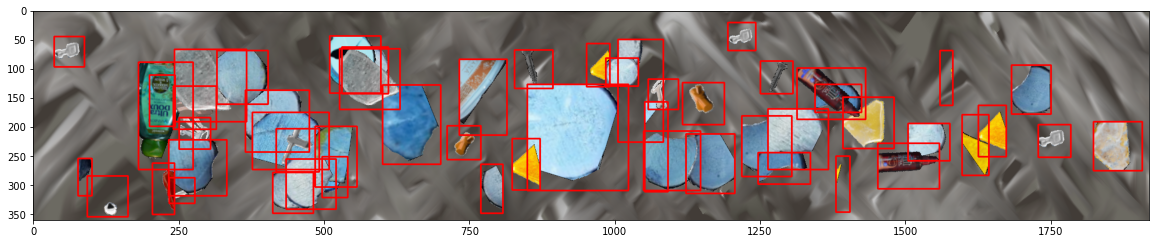

In [191]:

fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(img)

In [196]:
def make_frames(back_appl, bboxes, out_dir):
    h, w = back_appl.shape[1], back_appl.shape[2]
    curr_coord = 0
    step = 20
    frame_w = 640
    frame_h = h
    idx = 0
    out_w, out_h = 640, 640
    while curr_coord + frame_w < w:
        print(idx, curr_coord)
        out_label = []
        frame = back_appl[:, :, curr_coord: curr_coord+frame_w]
        for row in bboxes:
            bx = int(row['bbox'][0])
            by = int(row['bbox'][1])
            bw = int(row['bbox'][2])
            bh = int(row['bbox'][3])
            if bx - bw//2 < curr_coord and bx + bw//2 > curr_coord:
                out_label.append([row['label'],
                                  (bx+bw//2 - curr_coord)//2,
                                  by,
                                  bx+bw//2- curr_coord,
                                  bh])
            elif bx + bw//2 > curr_coord + frame_w and bx - bw//2 < curr_coord + frame_w:
                nw = frame_w - (bx-bw//2-curr_coord)
                out_label.append([row['label'],
                                  frame_w - nw//2,
                                  by,
                                  nw,
                                  bh])
            else:
                out_label.append([row['label'],
                                  bx-curr_coord,
                                  by,
                                  bw,
                                  bh])
#             print(out_label[-1])
#             
        out_channels = []
        for channel_id in range(14):
            new_arr = np.zeros((640, 640))
            new_arr[0:360, :] = frame[channel_id, :,:]
            out_channels.append(new_arr)
        out_arr = np.stack(out_channels)
        img_curr = out_arr[0:3,:,:].transpose((1, 2, 0)).astype(np.uint8).copy()
        for lb in out_label:
            start_point = [lb[1]-lb[3]//2,lb[2]-lb[4]//2]
            end_point = [lb[1]+lb[3]//2,lb[2]+lb[4]//2]
            img_curr = cv2.rectangle(img_curr, start_point, end_point,(255,0,0), 2)
#         np.save(os.path.join(out_dir, str(idx)+'_test6.npy'),out_arr, allow_pickle=False)
#         with open(os.path.join(out_dir, str(idx)+'_test6.txt'),'w') as f:
#             for annot in out_label:
#                 f.write('{} {} {} {} {}\n'.format(*annot))
        plt.imshow(img_curr)
        plt.show()
        idx=idx +1
        curr_coord = curr_coord + step

0 0


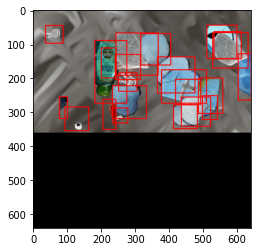

1 20


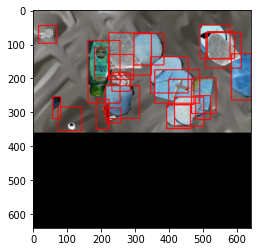

2 40


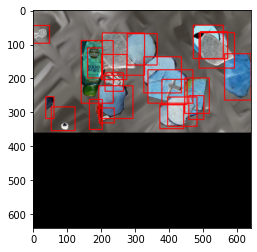

3 60


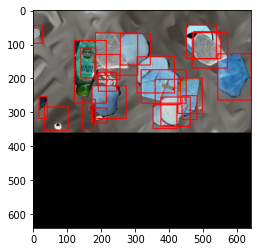

4 80


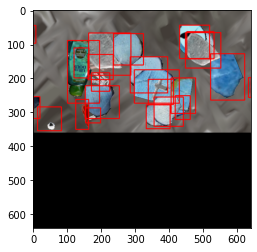

5 100


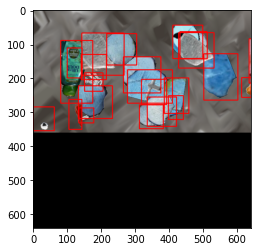

6 120


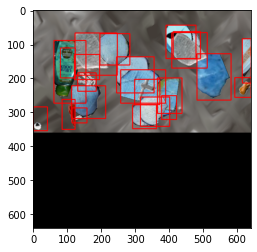

7 140


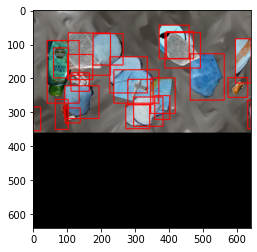

8 160


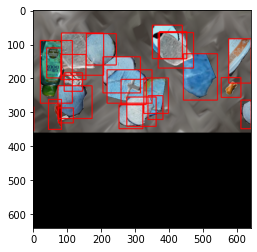

9 180


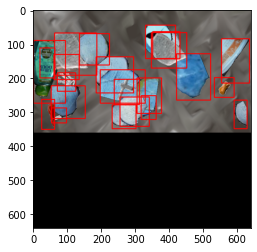

10 200


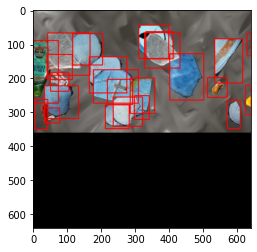

11 220


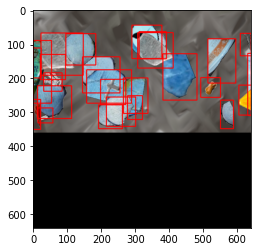

12 240


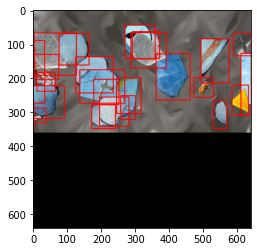

13 260


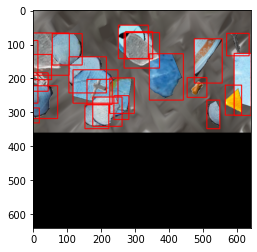

14 280


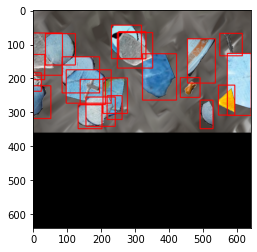

15 300


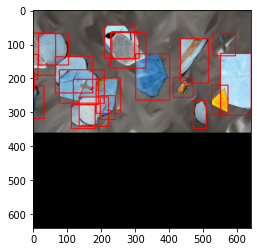

16 320


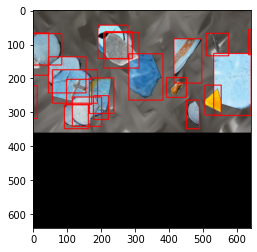

17 340


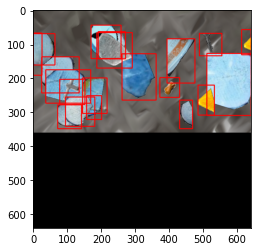

18 360


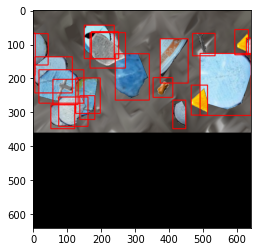

19 380


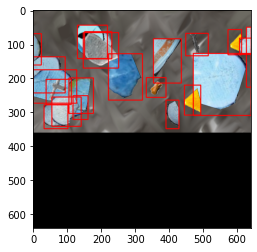

20 400


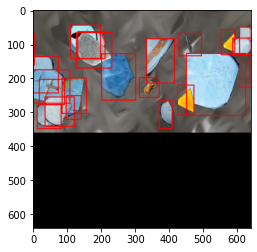

21 420


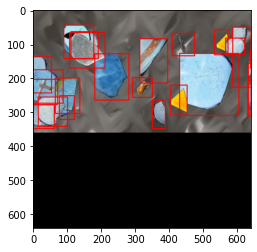

22 440


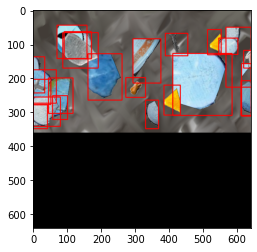

23 460


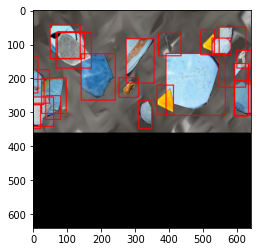

24 480


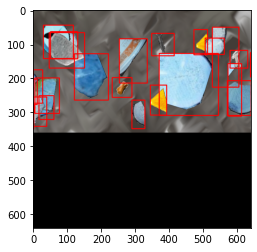

25 500


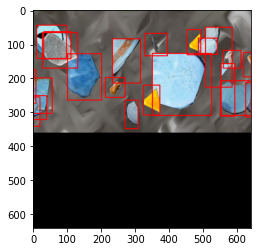

26 520


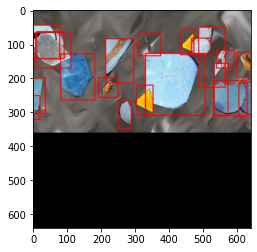

27 540


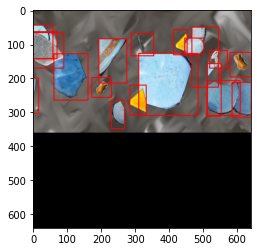

28 560


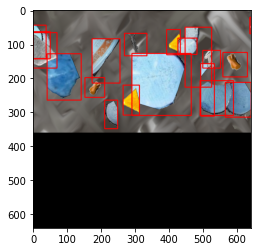

29 580


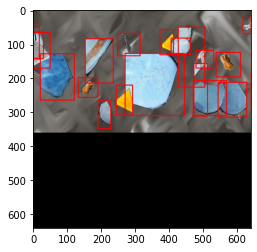

30 600


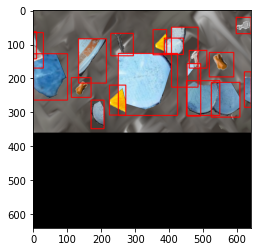

31 620


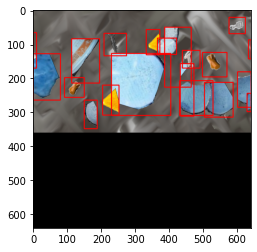

32 640


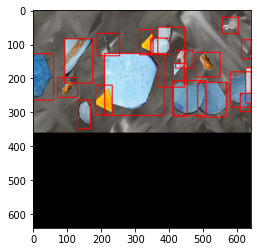

33 660


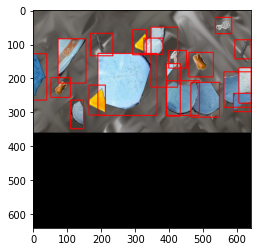

34 680


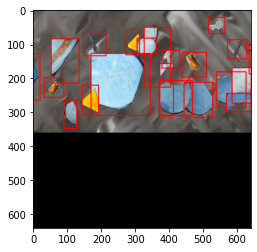

35 700


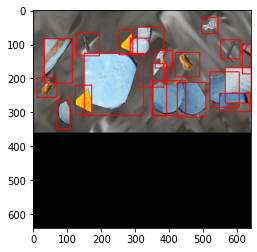

36 720


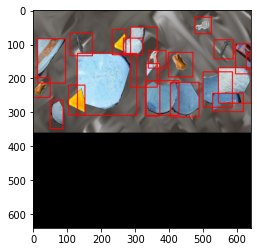

37 740


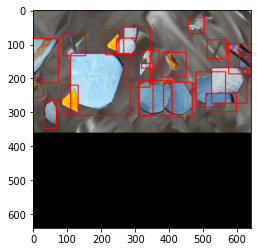

38 760


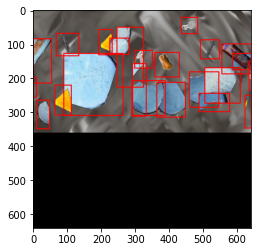

39 780


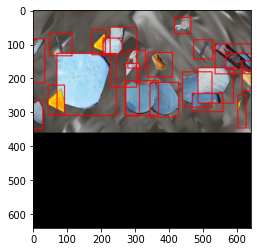

40 800


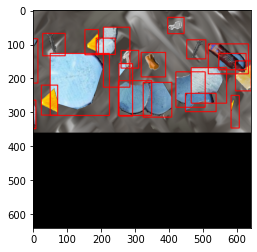

41 820


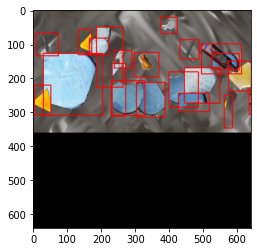

42 840


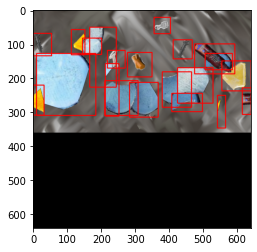

43 860


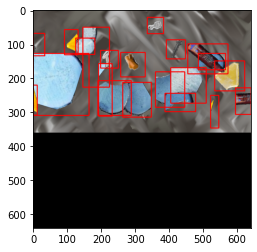

44 880


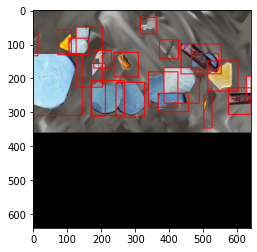

45 900


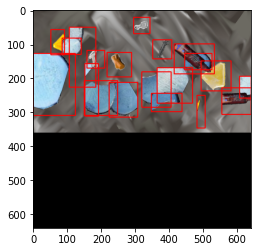

46 920


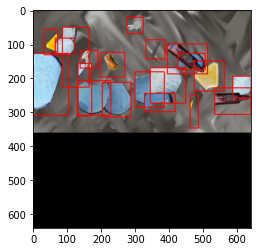

47 940


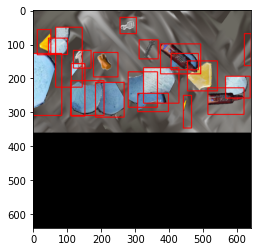

48 960


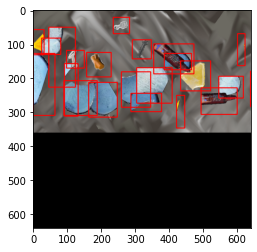

49 980


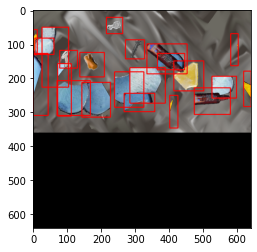

50 1000


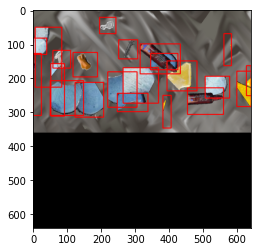

51 1020


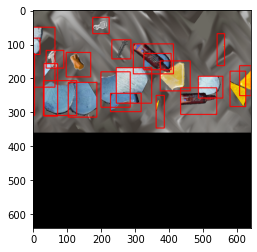

52 1040


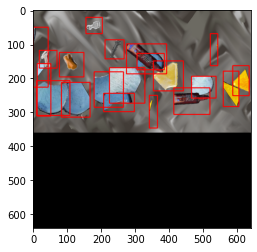

53 1060


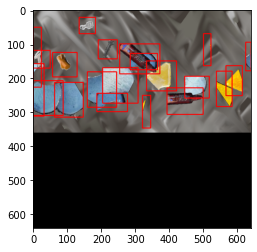

54 1080


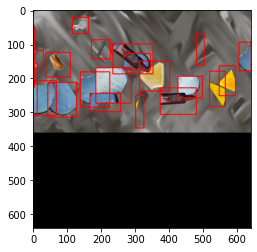

55 1100


KeyboardInterrupt: 

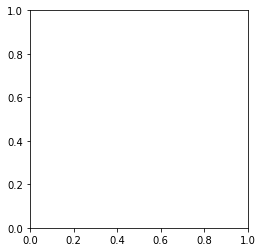

In [197]:
make_frames(back_appl, bboxes, './frame1/')